# Libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
import warnings


warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:
data = pd.read_excel("dataset.xlsx")

In [3]:
data.shape

(29, 2)

# EDA

In [4]:
data.head()

,Sentence,Outcome
0,What is the difference between depression and ...,C
1,What are other psychiatric conditions that can...,C
2,Why is depression more prevalent in women than...,C
3,What happens during menopause with regards to ...,C
4,What efforts are underway to improve treatment...,C


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  29 non-null     object
 1   Outcome   29 non-null     object
dtypes: object(2)
memory usage: 592.0+ bytes


In [6]:
cols=data.columns
cols

Index(['Sentence', 'Outcome'], dtype='object')

In [7]:
data=pd.DataFrame(data,columns=cols)

In [8]:
import copy
df_cpy=copy.deepcopy(data)
cols=np.array(data.columns[data.dtypes != object])
for i in df_cpy.columns:
    if i not in cols:
        df_cpy[i]=df_cpy[i].map(str)

In [9]:
df_cpy.head(20)

,Sentence,Outcome
0,What is the difference between depression and ...,C
1,What are other psychiatric conditions that can...,C
2,Why is depression more prevalent in women than...,C
3,What happens during menopause with regards to ...,C
4,What efforts are underway to improve treatment...,C
5,Why have researchers so far failed to identify...,C
6,Could other health conditions be contributing ...,C
7,Is depression treatable?,I
8,How is depression diagnosed and treated?,I
9,What is the most promising recent development ...,I


In [10]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# build dictionary function
cols=np.array(data.columns[data.dtypes != object])
d = defaultdict(LabelEncoder)

# only for categorical columns apply dictionary by calling fit_transform 
df_cpy = df_cpy.apply(lambda x: d[x.name].fit_transform(x))
df_cpy[cols] = data[cols]

In [11]:
cols=df_cpy.columns

In [12]:
df_cpy=pd.DataFrame(df_cpy, columns=cols)

In [13]:
len(df_cpy.columns)

2

In [14]:
corr = df_cpy.corr()
corr.sort_values(["Outcome"], ascending = False, inplace = True)
print(corr.Outcome)

Outcome     1.000000
Sentence   -0.040044
Name: Outcome, dtype: float64


# Feature Vector and Target Variable

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import randint

In [131]:
X=df_cpy.drop(columns=['Outcome']).values
y=df_cpy['Outcome'].values

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
X_train.shape, X_test.shape

((20, 1), (9, 1))

In [149]:
rf = RandomForestClassifier(n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [2,3,5,7,9,10,15]
}

In [150]:
from sklearn.model_selection import GridSearchCV

In [151]:
grid_search = GridSearchCV(estimator=rf,param_grid=params,cv = 4,n_jobs=-1, verbose=1, scoring="accuracy")

In [152]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 210 candidates, totalling 840 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [2, 3, 5, 7, 9, 10, 15]},
             scoring='accuracy', verbose=1)

In [153]:
grid_search.best_score_

0.45000000000000007

In [154]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1)

In [155]:
classifier_rf=RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1)

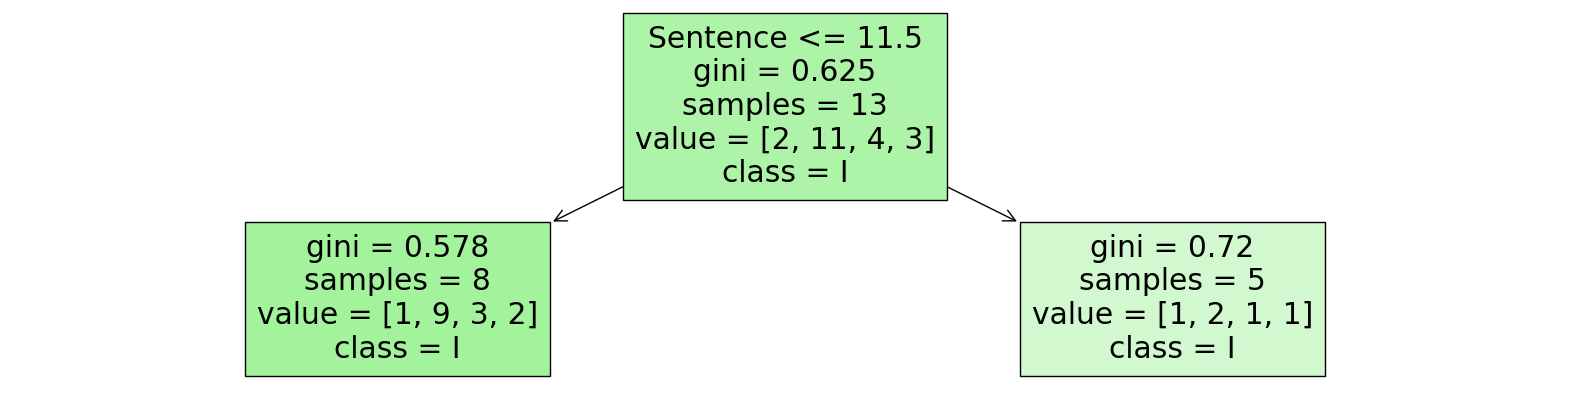

In [156]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,5))
plot_tree(rf_best.estimators_[1],feature_names=['Sentence'],class_names=['C','I','O','P'],filled=True);

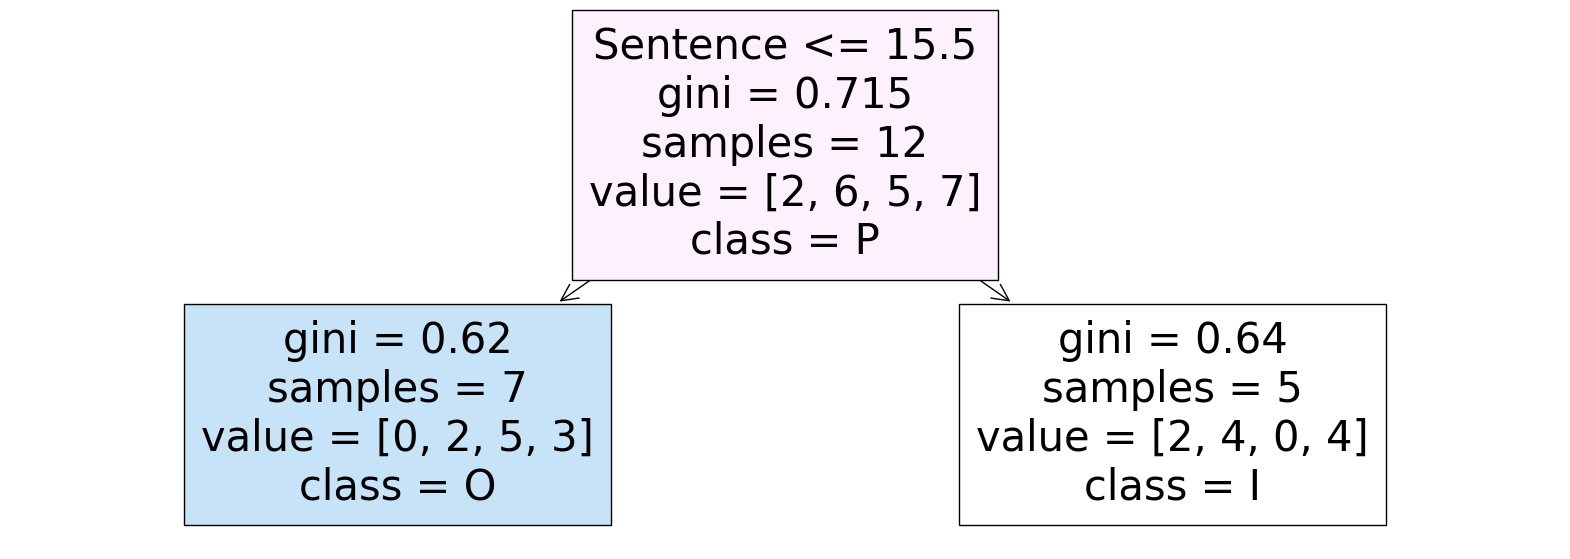

In [157]:
plt.figure(figsize=(20,7))
plot_tree(rf_best.estimators_[2],feature_names=['Sentence'],class_names=['C','I','O','P'],filled=True);

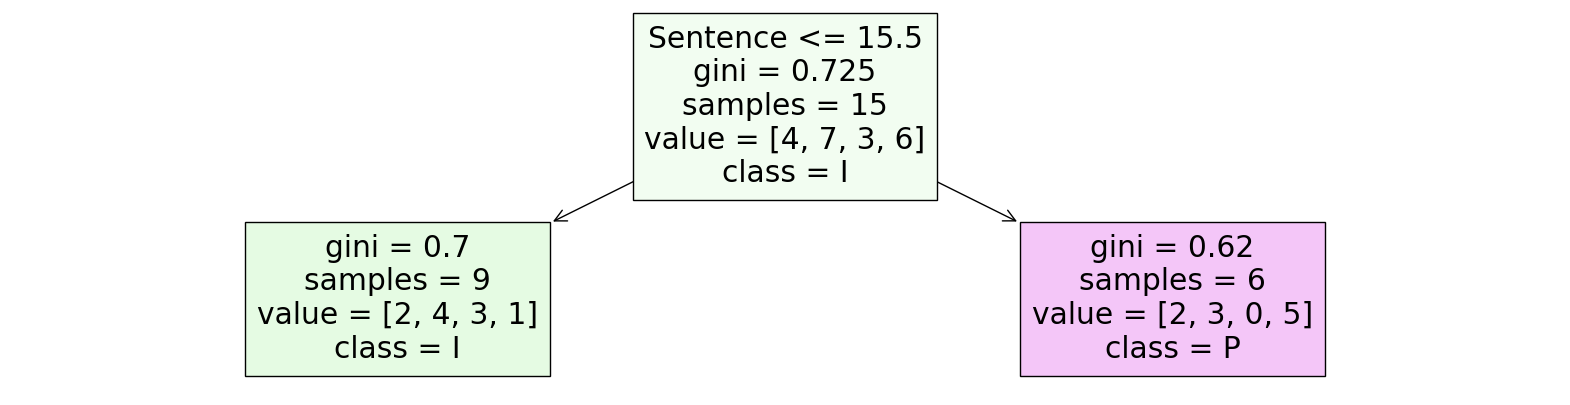

In [158]:
plt.figure(figsize=(20,5))
plot_tree(rf_best.estimators_[0],feature_names=['Sentence'],class_names=['C','I','O','P'],filled=True);

In [159]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

In [160]:
confusion_matrix(y_test, classifier_rf.predict(X_test))


array([[0, 0, 0, 4],
       [0, 0, 1, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]], dtype=int64)

In [161]:
Y_pred = classifier_rf.predict(X_test)  
acc_sc = accuracy_score(y_test, Y_pred)
print("{0:.3f}".format(acc_sc*100))

44.444


In [162]:
bal_acc_sc = balanced_accuracy_score(y_test, Y_pred)
bal_acc_sc*100

50.0

In [163]:
import pickle

with open('PICO_Classifier_RF','wb') as f:
    pickle.dump(classifier_rf,f)


In [111]:
from mlxtend.plotting import plot_decision_regions

def plotSVC(title):
    plot_decision_regions(X, y, clf=svc, legend=2)

    # Adding axes annotations
    plt.title(f'SVM {title}')
    plt.show()

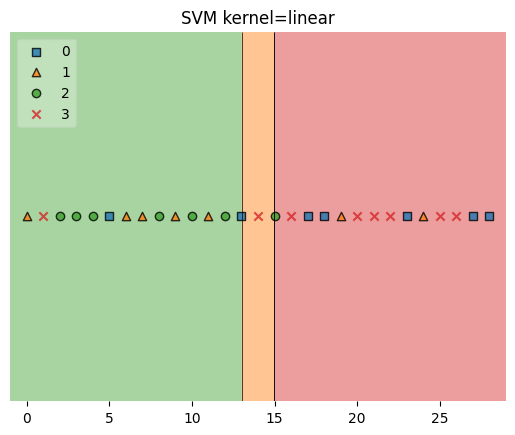

Accuracy: 0.2222222222222222


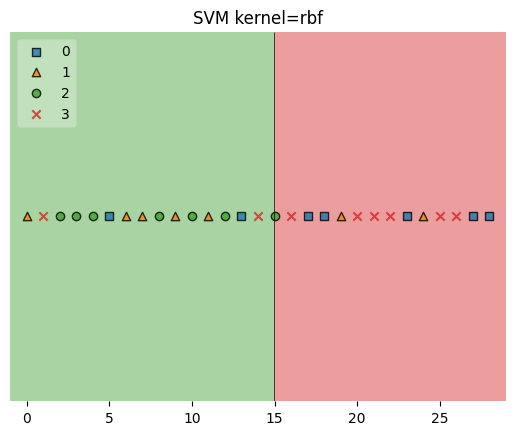

Accuracy: 0.2222222222222222


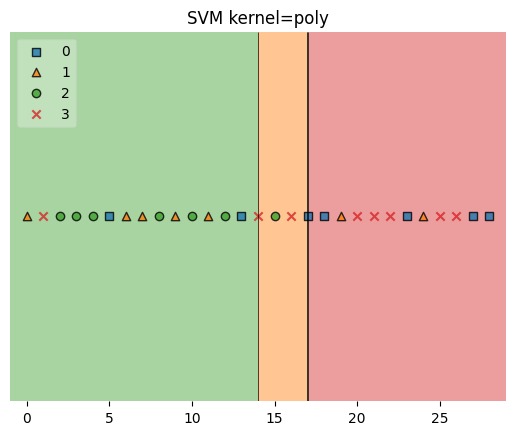

Accuracy: 0.2222222222222222


In [95]:
from sklearn.svm import SVC

kernels = ["linear", "rbf", "poly"]
for kernel in kernels:
    svc = SVC(C=0.5,kernel=kernel).fit(X, y)
    plotSVC("kernel=" + str(kernel))
    print("Accuracy:",accuracy_score(y_test,Y_pred))

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

Accuracy: 0.1111111111111111
Accuracy: 0.1111111111111111
Accuracy: 0.1111111111111111
Accuracy: 0.1111111111111111


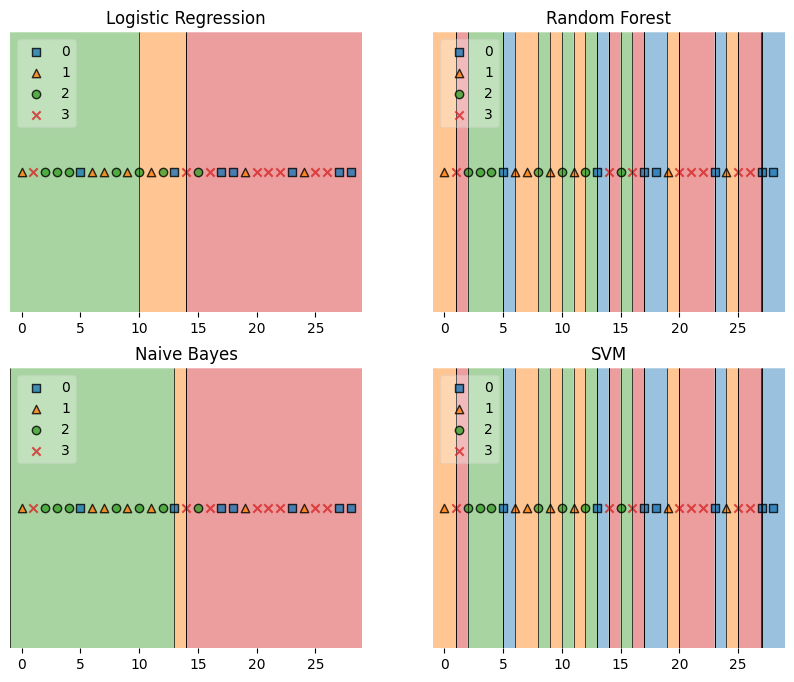

In [36]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
    print("Accuracy:",accuracy_score(y_test, Y_pred))

plt.show()

In [164]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 8)
scores = cross_val_score(classifier_rf, X, y, cv = k_folds)

In [165]:
scores

array([0.        , 0.        , 0.        , 0.25      , 0.        ,
       0.66666667, 0.        , 0.        ])

In [166]:
scores.mean()

0.11458333333333333

In [187]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [188]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [189]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train)
print(decision_tree_result)

{'Training Accuracy scores': array([nan, nan, nan, nan, nan]), 'Mean Training Accuracy': nan, 'Training Precision scores': array([nan, nan, nan, nan, nan]), 'Mean Training Precision': nan, 'Training Recall scores': array([nan, nan, nan, nan, nan]), 'Mean Training Recall': nan, 'Training F1 scores': array([nan, nan, nan, nan, nan]), 'Mean Training F1 Score': nan, 'Validation Accuracy scores': array([nan, nan, nan, nan, nan]), 'Mean Validation Accuracy': nan, 'Validation Precision scores': array([nan, nan, nan, nan, nan]), 'Mean Validation Precision': nan, 'Validation Recall scores': array([nan, nan, nan, nan, nan]), 'Mean Validation Recall': nan, 'Validation F1 scores': array([nan, nan, nan, nan, nan]), 'Mean Validation F1 Score': nan}


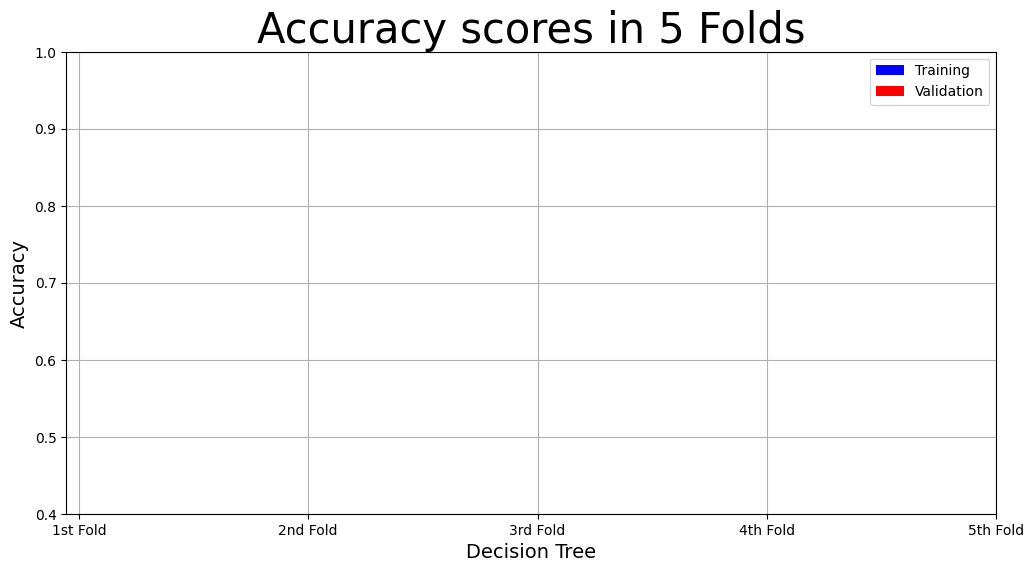

In [192]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result["Training Accuracy scores"],
            decision_tree_result["Validation Accuracy scores"])
